In [1]:
import pandas as pd

# 1. Read data
df = pd.read_csv('df_text.csv')
print(f"Shape: {df.shape}")

# 2. Extract victim from index (Region_Name_Number → Region_Name)
def extract_victim(idx):
    parts = idx.rsplit('_', 1)
    return parts[0] if len(parts) == 2 and parts[1].isdigit() else idx

df['victim'] = df['index'].apply(extract_victim)

# 3. Define label columns
LABEL_COLS = [
    'vic_grupo_social', 'amenaza_quien', 'captura_metodo', 'captura_tipo',
    'cautiverio_trato', 'desenlace', 'desenlace_tipo', 'perp_tipo1',
    'perp_tipo2', 'proced_contacto1', 'proced_contacto2', 'proced_contactado',
    'Tribunal_tipo', 'proced_sent_tipo', 'soc_civil'
]
label_cols = [c for c in LABEL_COLS if c in df.columns]

# 4. Aggregate by victim
def consensus(s):
    v = s.dropna()
    return v.mode().iloc[0] if len(v) and len(v.mode()) else None

agg = {'text': lambda x: '\n\n'.join(x.astype(str))}
agg.update({c: consensus for c in label_cols})

df_agg = df.groupby('victim', as_index=False).agg(agg)
df_agg['text_len'] = df_agg['text'].str.len()
df_agg['text_words'] = df_agg['text'].str.split().str.len()

# 5. Save
df_agg.to_csv('df_text_by_victim.csv', index=False)
print(f"{len(df)} rows → {len(df_agg)} victims")
print(f"Saved: df_text_by_victim.csv")
df_agg.head()


Shape: (2229, 19)
2229 rows → 575 victims
Saved: df_text_by_victim.csv


,victim,text,vic_grupo_social,amenaza_quien,captura_metodo,captura_tipo,cautiverio_trato,desenlace,desenlace_tipo,perp_tipo1,perp_tipo2,proced_contacto1,proced_contacto2,proced_contactado,Tribunal_tipo,proced_sent_tipo,soc_civil,text_len,text_words
0,Coahuila_Abel M H,5/10/2019\r\nLiberan a Matataxistas para ejecu...,People that work in service industries (taxi d...,None,Disappearance,Means and routes of transport and places of co...,None,Found dead,Unoccupied or barren public spaces,Particulars (when you cannot identify their af...,None,Relatives,None,Municipal police,None,None,No,6300,892
1,Coahuila_Agustin Alberto N M,Los desaparecidos que a nadie importan - Proce...,People that work in service industries (taxi d...,None,Levantón (kidnapping but pejorative use toward...,None,None,Still disappeared,None,Army,None,Relatives,None,Ministerial police (they are affiliated with t...,None,None,Yes (explain more in the final comments section),34236,5513
2,Coahuila_Agustin H G,5/22/2019\r\nDesaparecen otros siete michoacan...,People that work in service industries (taxi d...,None,Disappearance,None,None,Still disappeared,None,None,None,Relatives,None,District attorney's office,None,None,No,26982,4026
3,Coahuila_Alberto G H,5/22/2019\r\nDesaparecen otros siete michoacan...,People that work in service industries (taxi d...,None,Disappearance,None,None,Still disappeared,None,None,None,Relatives,None,District attorney's office,None,None,No,12446,1683
4,Coahuila_Antonio H H,23/4/2019\r\n23 de abril de 2019\r\nActivan Al...,None,None,Disappearance,None,None,Still disappeared,None,None,None,None,None,District attorney's office,None,None,No,11915,1784


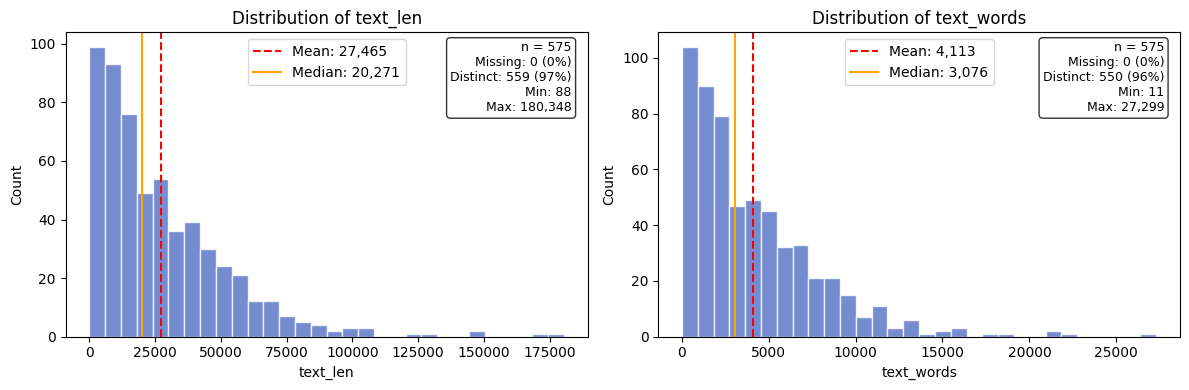

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col in zip(axes, ['text_len', 'text_words']):
    data = df_agg[col].dropna()
    
    # Plot histogram
    ax.hist(data, bins=30, color='#5470c6', edgecolor='white', alpha=0.8)
    
    # Add mean and median lines
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:,.0f}')
    ax.axvline(median_val, color='orange', linestyle='-', linewidth=1.5, label=f'Median: {median_val:,.0f}')
    
    # Stats text
    stats_text = (
        f"n = {len(data)}\n"
        f"Missing: {df_agg[col].isna().sum()} ({df_agg[col].isna().mean()*100:.0f}%)\n"
        f"Distinct: {data.nunique()} ({data.nunique()/len(data)*100:.0f}%)\n"
        f"Min: {data.min():,.0f}\n"
        f"Max: {data.max():,.0f}"
    )
    ax.text(0.97, 0.97, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {col}')
    ax.legend(loc='upper center')

plt.tight_layout()
plt.savefig('plots/text_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
